# Demonstration of the TEMMETA package

## First it's good to import some modules

In [1]:
# Since this file is located in TEMMETA/examples, we have to add the parent folder to sys.path to
# import our libary
import sys
sys.path.append("..")
# numpy is for working with data arrays
import numpy as np
# pyplot is for making and manipulating plots
import matplotlib.pyplot as plt

In [2]:
from importlib import reload

## We also set the plotting "back-end", this means where the plots will appear.
with the back-end "notebook" the plots will appear embedded in this notebook. You could also use qt
which will make pop-up windows.

In [3]:
%matplotlib notebook

## Here we import the most important TEMMETA modules
With data_io (imported here as dio) we can open and extract data objects from EMD files. 
It's possible that as the project evolves, the names of modules and packages will be changed

In [4]:
from basictools import data_io as dio

In [5]:
from basictools import image_filters as imf

In [6]:
from basictools import plottingtools as pl

In [136]:
reload(pl)
reload(dio)
reload(imf)

<module 'basictools.image_filters' from '../basictools/image_filters.py'>

I specify the path to a number of EMD files. In the repository that you cloned, these files are not there. 
If you want to look at the same files, please download them from:

* url1
* url2

Then update the paths to where these files reside

In [8]:
emd1_path = "../examples/data/SuperX-HAADF 1913.emd"
emd2_path = "../examples/data/88_20_ SI 1511 15.7 Mx EDS-HAADF 20200307.emd"
emd3_path = "../examples/data/191205-2F/17_ 20191205 1.4 Mx Imaging Ceta 1428.emd"

Here we import the first emd file and open it as an h5py File object with some extensions. 
This will allow us easy access to the datasets.

In [20]:
emd1 = dio.EMDFile(emd1_path)

You can visualize the datasets inside the emd file as in the next cell. This reveals the datasets that can be read in and converted to TEMMETA dataset objects for further processing

In [21]:
emd1.print_simple_structure()

------------------------------
        Image datasets        
------------------------------
Dataset number: 0, UUID: 6fdbde41eecc4375b45cd86bd2be17c0, Shape: 256x256, Frames: 240, Data type: uint16, Min:17381, Max:57476
---------------------------------------
        SpectrumStream datasets        
---------------------------------------
Dataset number: 0, UUID: f5a4ba0965a5444b8c46cc420cf7fef0, Length: 15933353, Data type: uint16, 



To extract the data from the dataset and create a nice easy object to work with, you need to pass in the dataset type and UUID, which uniquely identifies the dataset. You can get this from the table above. Here we extract the first dataset, representing an image stack. TEMMETA will try its best to recognize what type of dataset it is and create the appropriate one.

In [137]:
stack = emd1.get_dataset("Image", "6fdbde41eecc4375b45cd86bd2be17c0")

You can see that "stack" variable now contains a GeneralImageStack object.

In [ ]:
type(stack)

TEMMETA also parses the metadata and tries to fill in all things related to the scale and units of the images. It stores all this in a Metadata nested dictionary-type object which can be inspected as in the following cell. The metadata format and names are inspired by the format inside the emd files and tries to keep as much of the information as possible. However we throw away all of the stuff that seems redundant and uninformative, and linked information is better grouped and organized. I also adopted the python convention of using mostly lower case names. Our format contrasts the metadata in Hyperspy, mainly in that the latter throws out a lot of the metadata and only keeps what is relevant to the dataset itself. This metadata format tries to be intuitive to the microscopist (i.e. store a section on the "illumination", a section on the "imaging", a section on the "acquisition"), yet more or less complete from the perspective of experiment reproducibility. 

In [ ]:
stack.metadata


Currently all "axis" information is also stored in the metadata, whereas hyperspy stores this as separate objects in the datasets. This "data_axis" information is essential for the correct interpretation and scaling of images and plots. Any type of tampering with this information can make the dataset object stop functioning properly. Currently I envision three types of axes: linear, function and lookup_table. 

* A linear axis is the easiest and most common: a data "bin", like a pixel or a channel, corresponds to a certain macroscopic value in a linear way. So in an image, 1 pixel may have a scale of 1 pm. In a spectrum, a channel may correspond to 1 eV. There could also be a certain offset: the first bin may not correspond to 0.
* A function axis is one where the real bin value can be easily expressed in some simple function of the bin index. Only simple operations are supported (\*,/,+,-,//,%). For example, time axes are added to some datasets to store information about scanning, and these axes are function axes. Currently, these axes remain unused but might see use in the future.
* Finally a lookuptable is the most general, whereby an array of values is stored with real values corresponding to each bin. A natural logarithmic axis would have to be stored in this way for example. Currently there are no examples of such axes. If such axes would become more used they will probably have to be stored separately from the metadata mainly to be able to keep the overview. These types of axes will become more useful for compatibility with the USID data format.

We can write the metadata to a file for later reference. This is done in the JSON format.

In [ ]:
stack.metadata.to_file("./stack_metadata.json")

You can also access individual attributes with dot-notation or dictionary-access notation. Values that should have a unit are stored as a "tuple" with a value and a unit.

In [ ]:
print(stack.metadata.acquisition.detector.name)
print(stack.metadata["acquisition"]["detector"]["collection_angles"]["begin"])

The original metadata present with the respective dataset in the EMD file is also stored in the object. After hyperspy, this is stored in original_metadata

In [ ]:
stack.original_metadata

Enough about metadata, let's look at the data and manipulation of it. We can create an interactive visualisation of the image stack with the following cell. This allows you to add a scalebar, check the different frames in the stack, and adjust contrast and brightness. I wanted to implement a "save" button also which opens up a dialog to save that frame, unfortunately this is not working at the moment, you will have to save frames manually

In [ ]:
stack.plot_interactive()

We can select a frame of the stack or we can average all the images

In [ ]:
frame123 = stack.get_frame(123)
av = stack.average()

These are now individual images, objects that have a different set of tools

In [ ]:
av.metadata

In [ ]:
print(type(frame123))
print(type(av))

## 1. Intensity profiles

One of the things you could do with an image dataset is make an intensity profile along a certain line defined by two points. You could first plot the image in an interactive way using `plot_interactive()` and then hover the mouse over where you would like to have the points of your line. The coordinates of the mouse will appear in the lower-right corner. Write these down and use them as coordinates.

In [ ]:
ax, im = av.plot(dpi=50)
# here we define our line and also add it to the plot for clarity
x1, y1 = (35, 101)
x2, y2 = (205, 101)
ax.arrow(x1, y1, x2-x1, y2-y1, color = (0., 1., 0.), head_width=5)
x3, y3 = (204, 200)
x4, y4 = (110, 20)
ax.arrow(x3, y3, x4-x3, y4-y3, color = (1., 0., 1.), head_width=5)

To create the line profile do the following. You could optionally set the w (width of the line in pixels) parameter. Pixels perpendicular to the line are added together. By default w=1. Here we create 4 profiles, also from the one frame so you can see the difference.

In [ ]:
# the green arrow in the averaged image
profil1 = av.intensity_profile(x1, y1, x2, y2)
# the green arrow in the averaged image but with a higher width
profil1_b = av.intensity_profile(x1, y1, x2, y2, w=3)
# the green arrow in the one frame, will be much more noisy
profil1_c = frame123.intensity_profile(x1, y1, x2, y2)
# the magenta arrow in the averaged image
profil2 = av.intensity_profile(x3, y3, x4, y4)

We can plot the profiles with their "plot" function. This returns an axis object and a list of plot objects (only one element in this case). You can use the axis to pass it to the plot function of another profile to plot them on the same figure.

In [ ]:
# plot returns the axis object 
ax, prof1 = profil1.plot()
_, prof1b = profil1_b.plot(axis=ax)
_, prof1c = profil1_c.plot(axis=ax)
_, prof2 = profil2.plot(axis=ax)
# we can modify the properties of the plots, like give each a label as such
prof1[0].set_label("Profile 1")
prof1b[0].set_label("Profile 1b")
prof1c[0].set_label("Profile 1c")
prof2[0].set_label("Profile 2")
# then we can autogenerate a legend
ax.legend()
# some layout optimization
ax.figure.tight_layout()

If we are not happy with the units, we can change them using `set_scale`. For example, we might prefer units of nm in the plot instead of m. So we will use the current `pixelsize` of the object and multiply by 1e9. We also set the unit to nm. This will change and overwrite the values in the metadata.

In [ ]:
profil1.set_scale(profil1.pixelsize*1e9, "nm")

Replotting shows that it was effective.

In [ ]:
profil1.plot()

Again a note on metadata. You can check the metadata of all derivative datasets again with the `metadata` attribute. Any derivative dataset stores the metadata of it's parent inside the `parent_meta` key. The process to arrive at the child dataset is stored in `process`. In this way the complete processing chain is kept inside the dataset metadata, as long as you perform operations on the object itself and not directly on the data. For the profile, we have a chain of two parents. The `original_metadata` in the measured dataset is no longer stored in derivative datasets.

With this philosophy of traceability, any time an operation is performed on a dataset, it will create and return a new object. The data from parent objects is not overwritten. If you want to keep using the same variable and perform operations on an object in place, most functions have the `inplace` argument which is `False` by default. If you set this to true, `data` and `metadata` will be updated, but the metadata will also show the operation-chain.

In [ ]:
print(profil1.metadata.process)
print(profil1.metadata.parent_meta.process)

Finally the intensity profile can be exported to an excel or a hyperspy dataset. Hyperspy takes a long time to load into memory so it is only loaded into memory once an export needs to take place. A filename can be optionally provided to save the object to a hyperspy file. A hyperspy file is also a hdf5 file, with a much more logical structure than Velox EMD files. You can import the file again later and continue working on it with hyperspy. All metadata related to the acquisition however is not stored in the hyperspy dataset.

In [ ]:
profil1.to_excel("profile1.xlsx")

In [ ]:
profil1_hs = profil1.to_hspy("profile1")

In [ ]:
type(profil1_hs)

## 2. GeneralImages

### 2.1 Plotting, basic filtering, basic operations and exporting

Images are of course the bread and butter of microscopy. Here I try to show some of the things you can do with the `GeneralImage` class. Intensity line profiles were already demonstrated before. We continue working on our averaged image calculated from the stack.

The main thing you will want to do with images is visualize them, apply filters, measure distances and angles, calculate Fourrier transforms, etc. For a quick look, we can also plot images with some interactive sliders. The sliders can at times be buggy which is an issue with matplotlib widgets.

In [ ]:
av.plot_interactive()

First we will also change the scale from m to nm on the image for convenience. While the scalebar is smart, for all kinds of measurements nm units will be more convenient. In addition, derived datasets, such as line profiles will also use the same units. 

*Note*: call this cell only once. If you call it twice then it will look again what the current pixelsize is and again multiply by 1e9.

In [ ]:
av.set_scale(av.pixelsize*1e9, "nm")

You can verify that it worked by checking the dimensions. this gives the size of the image in real units in a 4-tuple

In [ ]:
av.dimensions

Visualisation happens mainly through the plot command, it has innumerable options but they are a bit hidden. The main direct keyword arguments are `width` which determines the plot size on the screen (the scalebar is not scaled with the image size), `scalebar` which you set to `True` (default) or `False` to add a scalebar, `show_fig` (T/F) to show the figure or not (if it's only for export), `filename` (optional) for when you directly want to write out the plot to a file. You can pass arguments to the scalebar via `sb_settings` which accepts a dictionary of settings, while `imshow_kwargs` accepts a dictionary passed to the `imshow` command in pyplot. If you want to modify how the scalebar looks `sb_settings` is very important. Since the Axisimage object is returned, you can still change the settings of the image (like the colormap, the intensity scaling, etc) after you call the plot command.

For all the possible `sb_settings`, check out the [documentation of matplotlib-scalebar](https://pypi.org/project/matplotlib-scalebar/)

For all the possible `imshow_kwargs`, check out the [documentation on imshow](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html)

Here I just show one example of a non-standard plot

In [ ]:
scaleset = {"location": 'lower right',
            "color": "white",
            "length_fraction": 0.25,
            "frameon": True,
            "box_color": "black",
            "font_properties": {"size": 14, "weight": "bold"}}
imgset = {"cmap": "jet", "vmin": 2e4, "vmax": 5e4}
ax, im = av.plot(width = 10, sb_settings = scaleset, imshow_kwargs = imgset)

You could always change the `imshow` properties by accessing the Axesimage object stored in `im`. Check the documentation for the available methods or check stackexchange for specific questions you might have.

You can also access the figure itself through `ax.figure`. We will then save this to a file

In [ ]:
ax.figure.savefig("colorful.tiff")

We can apply functions to an image to change it into another image. Any function that takes in an a 2D image and outputs another 2D image could be considered a `filter`. You could write your own filters (currently there aren't so many implemented), and then you can use it with the `apply_filter` command. Inside, you provide the filter function as first argument and then all the arguments and keyword arguments that the filter might need. Output is another image object. 

Note that the function will always warn you that scales and units of the image may become incorrect, for example if the image is stretched or rebinned. By default the same pixelsize is kept, it is up to the user to evaluate whether the scale of the image should be updated.

In [ ]:
gaussfilt = av.apply_filter(imf.gauss_filter, ks=10, sig=5, cval = av.data.mean())
medfilt = av.apply_filter(imf.med_filter)
butterfilt = av.apply_filter(imf.bw_filter)

We can use the same settings as before to plot some these images, for example the butterworth filtered image

In [ ]:
butterfilt.plot(width = 10, sb_settings = scaleset, imshow_kwargs = imgset)

A few "filters" have been implemented as shorthand methods in the GeneralImage class already. These are currently:

* crop
* rebin
* linscale

Calling these methods, especially rebin, will automatically update the scale. You can add a cell and check with plotting that these functions worked

In [ ]:
av_crop = av.crop(78, 72, 121, 171)
av_rebin = av.rebin(factor = 2)
av_linscale = av.linscale(min=2e4, max=5e4)

How do you know which values to take for minimum and maximum in linear scaling of the intensity? One way is using the `plot_interactive` sliders to determine good thresholds. Another is to check the histogram of the image. This is easily done with `plot_histogram`. With this you can check where the bulk of the intensity is located and adjust the scale accordingly.

In [ ]:
av.plot_histogram()

Finally, we can also export our images to png, tiff, and hyperspy. With the `save` command, the image is by default exported as an 8-bit png. However, you can add options `min`, `max` and `dtype` to change this behavior, checkout `help(av.save)` for this. There is no scalebar applied. 

For exporting as tiff (by default with the same datatype as stored in the original dataset), we use the plot command as seen before, and export the plot by providing the `filename` argument. 

For creating a hyperspy dataset, we follow the same example as before.

In [ ]:
av.save("average.png")

In [ ]:
av.to_hspy("average")

### 2.2 FFT based operations

We can calculate the fast fourrier transform of images as long as they are square. You can actually calculate an FFT of an image of any size, but a non-square one is not so intuitive to interpret, so we don't allow it in TEMMETA. We can do a number of things on the FFT, mainly extracting fourrier components by masking and calculating the inverse fourrier transform. We can also calculate strain with GPA. These operations are demonstrated here on an HRTEM image dataset. We first import the emd file and extract the dataset

In [9]:
emd3 = dio.EMDFile(emd3_path)

In [10]:
emd3.print_simple_structure()

------------------------------
        Image datasets        
------------------------------
Dataset number: 0, UUID: 7c3929705ae04354b656fb2f929a1cfa, Shape: 4096x4096, Frames: 1, Data type: int16, Min:179, Max:1966



In [11]:
hrtemimg = emd3.get_dataset("Image", "7c3929705ae04354b656fb2f929a1cfa")

In [ ]:
hrtemimg.plot_interactive()

Scales are again in meters so we set it to nm

In [ ]:
hrtemimg.set_scale(hrtemimg.pixelsize*1e9, "nm")

We access the fft with

In [13]:
fft = hrtemimg.fft

For quick visualisation of the FFT and for things like coordinate selection for creating masks, there is the plot function. Note however that an FFT is complex valued so what is actually plot is a power spectrum on a log scale. The function will warn you of this. For optimizing the image of the FFT in case you want to write this out, make an image from the real or imaginary component, or from the argument or phase.

An FFT is complex-valued and can not be visualized as an image. Actually plot here is a smoothed power spectrum, logarithmically scaled. If the FFT in point (x, y) is a+bi, then the image intensity there is log10(a^2+b^2)


<IPython.core.display.Javascript object>


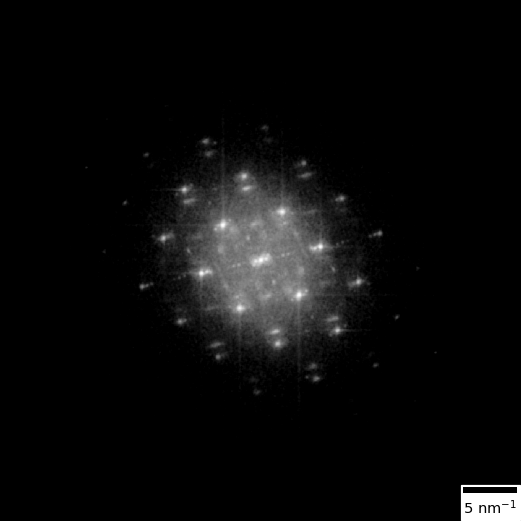

In [14]:
ax, im = fft.plot()
im.set_clim(0.7, 1)

For example, I might want this same image but without a scale bar, with some modified intesity scaling, and with a different colormap. Below is an example. In the first cell we extract the power spectrum (log scaled), then we apply a median filter, then we plot with a few additional parameters

In [ ]:
ps = fft.power_spectrum

In [ ]:
psf = ps.apply_filter(imf.med_filter)

In [ ]:
msize = 800 # some variable for the window size
ax, im = psf.plot(scale_bar=False, width=20, imshow_kwargs={"cmap": "hot", "vmin": 100, "vmax": 150})
ax.set_xlim(ps.width//2-msize//2, ps.width//2+msize//2)
# note that to keep the same orientation as the image, we have to go from positive to negative on the y-axis
# This is because when plotting images, the y-axis points from the top left corner downwards.
ax.set_ylim(ps.height//2+msize//2, ps.height//2-msize//2)

Saving this figure

In [ ]:
ax.figure.savefig("fft.png")

So much for visualizing and plotting the fft.

Now we will try to do some more operations on the FFT stored in `fft`. You can measure distances and angles on the FFT like in images beforehand. There is a small difference, in that if you provide only one point, it will automatically take the central spot as the second point. You can see this in the following cell

In [ ]:
print(fft.measure(2151, 2140))
print(fft.measure(fft.width/2, fft.height/2, 2151, 2140))

We can get an ifft from the FFT via `ifft`. If we get the ifft from our fft without processing we retrieve our original image.

*Note: The IFFT is also a complex valued array in general. If the FFT is symmetric over 0 then the IFFT will be real-valued except for small rounding errors. Still, what we actually return as an FFT is the modulus. So if you invert a non-centrosymmetric FFT, the ifft is complex valued. But in this implementation, we always take the modulus to work with and plot a real image.*

In [ ]:
ifft = fft.ifft

In [ ]:
ifft.plot()

You should know however that it is not completely the same. Due to the calculations, the values are converted to floating point numbers with decimals. You will see this when you check the `dtype` of the data. Due to various rounding errors there will be a slight but negligible difference between the values in each pixel. 

In [ ]:
ifft.data.dtype

The metadata will keep track of these operations

In [ ]:
ifft.metadata

We will now create some masks for the FFT. This allows us to select/exclude certain spatial frequencies. We can then see the effect on the image with an inverse fourrier transform. A mask is nothing but an array of the same size as the FFT with values between 0 and 1. Multiplying the mask element-wise with the FFT will act as a frequency filter. Any grayscale image of the same size as the FFT can act as a mask. With TEMMETA we provide a wrapper class Mask, which includes a few handy functions for adding elements to it.

In TEMMETA, a Mask is initialized as either a positive or a negative mask. A positive mask is where all the elements are intialized as 1. If no features are added, everything passes the filter. Features added are "black", so you add features to exclude frequencies from the FFT. A negative mask is initilized at 0 and nothing is passed. Features added are "white", so these are made to allow some frequencies through. For high resolution microscopy, negative masks with a few "holes" are the most common, so this is the default behavior. If you want to change the default behavior use the argument `negative=False`. You can also always invert a mask with the method `invert()`.

We can instantiate a `Mask` object directly from the FFT.

In [ ]:
m1 = fft.create_mask()

We then use the methods of `Mask` to add features to it. Currently implemented are (check their help for details):

* **add_circle** adds circles on both sides of the central spot. You can add a circle on only one side with `mirrored=False`.
* **add_square** adds squares on both sides of the central spot. Again `mirrored` can be used.
* **add_band** adds a pass-band: two concentric circles around the central spot
* **add_array1D** adds a row of circles. `mirrored` can be used. The center is not blanked.
* **add_array2D** adds a 2D grid of circles over the image determined by 2 basis vectors. If the vectors are co-linear, some unexpected behavior can occur. The center is not blanked.

In the case of a negative mask (all is 0), you "poke holes" (where value is 1) in it of various shapes. In the case of a positive mask (all is 1), you "paint features" (where value is 0) over it. You can also paint features in negative masks or poke holes in positive masks, for example to poke a hole in a painted feature. All these things are illustrated below. 

In [ ]:
# some partially overlapping circles which are mirrored
m1.add_circle(2107, 1923, 25, edge_blur=5)
m1.add_circle(2150, 1923, 25, edge_blur=5)
m1.add_circle(2150, 1970, 50, edge_blur=15)
# paint a small circle on a previous hole
m1.add_circle(2150, 1923, 5, edge_blur=0, negative=True)
# a square which is not mirrored
m1.add_square(2150, 2142, 20, edge_blur=2, mirrored=False)
# a pass-band
m1.add_band(20, 50, edge_blur=2)
# a 2D array
m1.add_array2D(2335, 2124, 1981, 1614, 10, edge_blur=0)

You can visualize the mask directly with `plot`. Use the zoom button to inspect the mask in greater detail.

In [ ]:
m1.plot()

You can invert the mask to turn it from positive to negative and vice versa

In [ ]:
m1.invert()
m1.plot()

I hope with this example you see you have a lot of options to designing an appropriate FFT mask. Of course this example is a bit nonsense, so we will create one relevant to our fft with a 2D array reflecting the periodicity of the lattice. I measured the (x,y) coordinates on a plot of the fft, then enter them into the function below.

In [ ]:
m2 = fft.create_mask()
m2.add_array2D(2204, 2012, 2147, 2140, 10)

I can check the mask on top of the fft with `check_mask` or `check_masked`. The first plots the mask as a partially transparent image over the power spectrum. The second plots the power spectrum if the fft is masked. With the values that are returned from the plot function I can also optimize the plot a bit.

In [ ]:
ax, imfft, immask = fft.check_mask(m2)
imfft.set_clim(100, 150)

When we are happy with our mask we can apply it to the FFT and then take the inverse Fourrier transform

In [ ]:
fft_masked = fft.apply_mask(m2)

In [ ]:
ifft_masked = fft_masked.ifft

`ifft_masked` is again an image which we can use for the same kinds of operations as before

In [ ]:
ifft_masked.plot()

Once again, the metadata has kept a record of the operations. Unfortunately, the metadata doesn't save any information about the mask itself. For completeness, the mask is best converted to an image and saved to a file

In [ ]:
ifft_masked.metadata

In [ ]:
mimg = m2.to_image()
mimg.save("mask.png")

I also implemented a **very** basic version of geometric phase analysis (GPA) [(Hytch et al., 1998)](doi.org/10.1016/S0304-3991(98)00035-7), which calculates strain maps in HRTEM images. The application is pretty basic: use the method `calc_strains` on the image. You must provide as arguments the coordinates of two spots in the FFT, from which phase images are internally calculated and processed. For the other arguments, check the documentation with `help`. For a large image as this one the calculation can take quite some time, half a minute to a minute or two. 

The method returns 4 image objects representing different strain components: epsilon_xx, epsilon_yy, epsilon_xy, the components from the symmetric strain matrix, and omega_xy, the off-diagonal element of the antisymmetric term representing rigid rotation. These can be plot and worked with as any other image, see previously. Note also that since this method is based on derivatives of the phase, the output images are 1 pixel less wide and high than the original.

An additional argument that can be used is `angle`, which describes the strain tensor in another coordinate system. If your desired x-axis lies 30 degrees with the horizontal for example, `angle=30` and epsilon_xx will represent the tensile/compressive strain in this direction.

**The method must still be verified against other implementations and better datasets, don't trust the result yet for your publications**

Here a demonstration of how it's supposed to work. we will use a subset of hrtemimg from before. We use crop and to keep it square and a power of two, we add the argument nearest_power=True.

In [15]:
imgcropped = hrtemimg.crop(1809,2077,3300,3381, nearest_power=True)

<IPython.core.display.Javascript object>


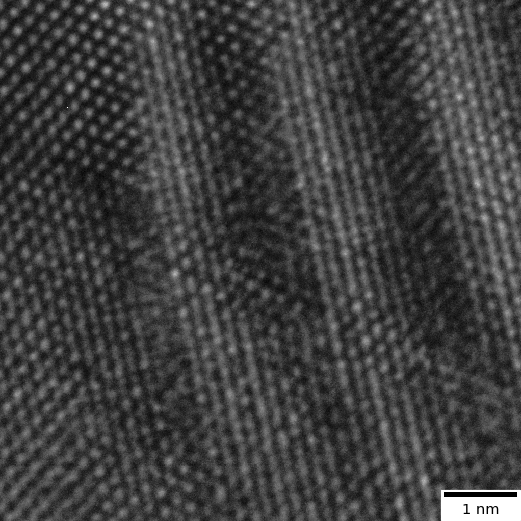

(<matplotlib.axes._axes.Axes at 0x1c77e4d850>,
 <matplotlib.image.AxesImage at 0x1c2559e290>)

In [16]:
imgcropped.plot()

We now check the FFT and find the coordinates of spots we want to select

An FFT is complex-valued and can not be visualized as an image. Actually plot here is a smoothed power spectrum, logarithmically scaled. If the FFT in point (x, y) is a+bi, then the image intensity there is log10(a^2+b^2)


<IPython.core.display.Javascript object>


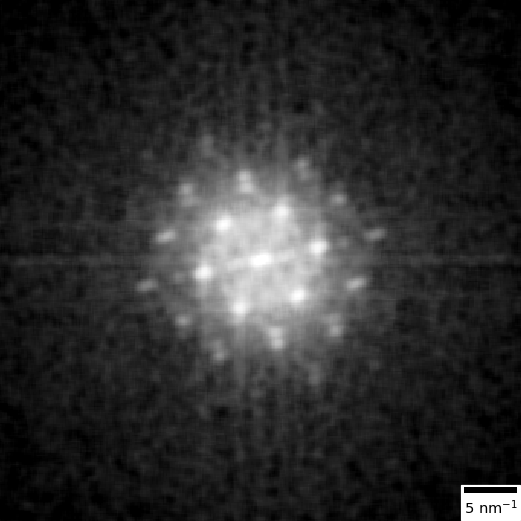

In [17]:
fft_crop = imgcropped.fft
ax, im = fft_crop.plot()
im.set_clim(0.7, 1)

In [18]:
xx1, yy1 = 536, 536
xx2, yy2 = 550, 503
exx, eyy, exy, oxy = imgcropped.calc_strains(xx1, yy1, xx2, yy2, r=8, edge_blur=5)

To make a somewhat more complex plot and put all images on the same figure, I access the data inside these GeneralImage objects directly and use matplotlib. In this way you can check how changing the parameters in the cell above changes the output. The result in general looks pretty crappy, but then again this isn't the best dataset.

<IPython.core.display.Javascript object>


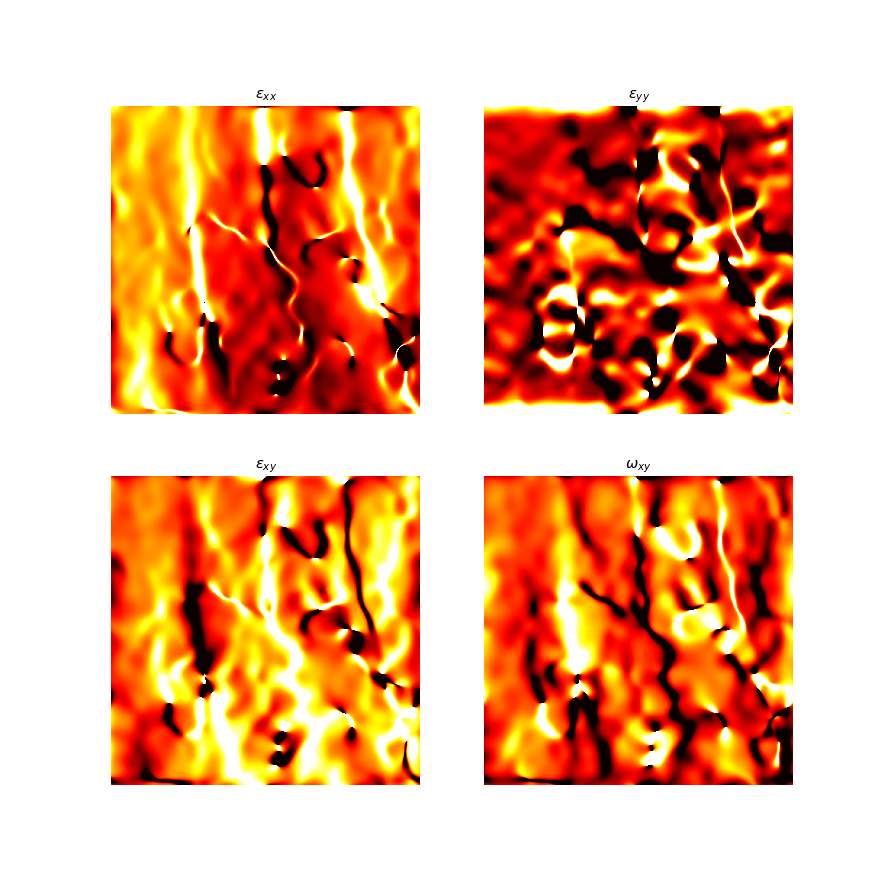

In [19]:
fig, axes = plt.subplots(2, 2, figsize = (10,10))
(ax1, ax2), (ax3, ax4) = axes

kwargs = {"cmap": "hot", "vmin":-0.1, "vmax":0.1}
# exx
ax1.imshow(exx.data, **kwargs)
ax1.set_title(r"$\epsilon_{xx}$")
ax1.set_axis_off()
# eyy
ax2.imshow(eyy.data, **kwargs)
ax2.set_title(r"$\epsilon_{yy}$")
ax2.set_axis_off()
# exy
ax3.imshow(exy.data, **kwargs)
ax3.set_title(r"$\epsilon_{xy}$")
ax3.set_axis_off()
# oxy
ax4.imshow(oxy.data, **kwargs)
ax4.set_title(r"$\omega_{xy}$")
ax4.set_axis_off()

### 2.3 Peak fitting

## 3. GeneralImageStack

Image stacks arrise mainly due to multiple frames being captured over time. We already showed a little bit of what one can do with a stack. The bulk of the analysis in principle happens in individual images, so you would convert frames or average multiple frames into one image and then work with it. But some operations you might like to do on all the images in the stack. Currently, the options are a bit limited but may expand as more of people's needs come to light.

### 3.1 Selection of frames, selection of areas, creating images

Let's revisit the stack from before stored in `stack`. We can either access individual frames with `get_frame` or we can create new stacks with `select_frames` or `exclude_frames`

In [23]:
frame203 = stack.get_frame(203)

In [24]:
frames_select = [1, 3, 5]
stack_select = stack.select_frames(frames_select)

In [55]:
stack_exclude = stack.exclude_frames(frames_select)

If you select only one frame the returned object is an image which you can process in the same ways as before. If you select frames, returned is a new stack which you can further process. 

To select areas you can use the `crop` command, with the same behavior as for images, only that here it is applied to all frames. You could again use the `nearest_power` argument to make sure your selection is a square of size $2^n \times 2^n$

In [57]:
stack_cropped = stack.crop(50, 50, 120, 75)

### 3.2 Applying filters on all frames

The basic filters `linscale` and `rebin` also work on an image stack. There is also `apply_filter` which just loops over all the frames and applies the filter. Some of these operations can be quite slow. There is an option to use multiprocessing to speed up the calculations a bit - don't expect magic though

In [131]:
stack_linscaled = stack.linscale(1e4, 4e4)

In [141]:
stack_rebinned = stack.rebin(1.5, multiprocessing=True)

In [149]:
# here we demonstrate the minor differences between using multiprocessing and not. kw args are just
# to be passed to the function.

from time import time

start = time()
stack_gausfilter = stack.apply_filter(imf.gauss_filter, multiprocessing=False, sig=5)
stop = time()
print(f"{(stop-start)} seconds without multiprocessing")

start = time()
stack_gausfilter = stack.apply_filter(imf.gauss_filter, multiprocessing=True, sig=5)
stop = time()
print(f"{(stop-start)} seconds with multiprocessing")

The pixel size and unit of the original images were used. The scale may no longer be correct. Please verify and use set_scale.


1.943310022354126 seconds without multiprocessing


The pixel size and unit of the original images were used. The scale may no longer be correct. Please verify and use set_scale.


0.9493680000305176 seconds with multiprocessing


<IPython.core.display.Javascript object>


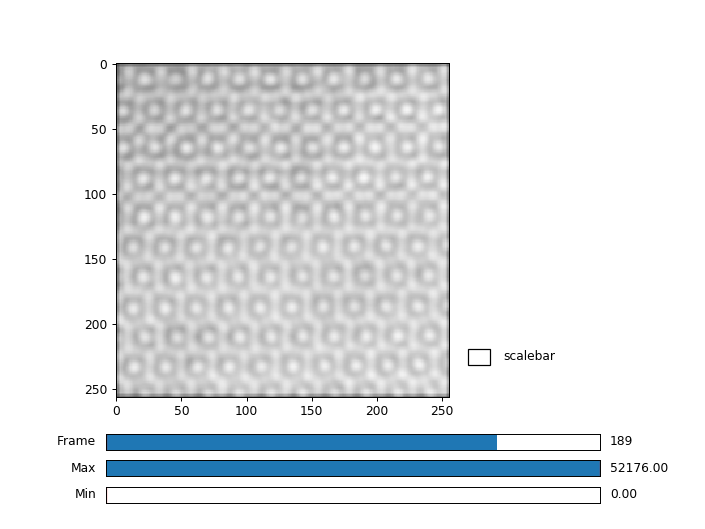

In [148]:
stack_gausfilter.plot_interactive()

### 3.3 Aligning frames

Aligning features in different images is a process called *image registration*. If it is assumed the only difference between the images are shifts are rotations, aligning the images is called *rigid registration*. If there are deformations between the images, aligning features in the images requires destoring the images and is a very complex process called *non-rigid-registration*.

The most basic rigid registration algorithm (only correcting translations) is implemented in TEMMETA and can be applied on a stack using `align_frames`. It works by selecting a small square in the first image and calculating the cross-correlation between this square and all the other images. The maximum in the cross-correlation may be shifted from the center and this shift is applied on the frames. No deformations in individual frames can be corrected this way! The method returns both a new stack and the (x, y) shifts for each frame. These you could use to align a spectrum stream.

If you require non rigid registration (for example for strain measurements) you may want to look at [`match-series`](https://github.com/berkels/match-series) implemented by Benjamin Berkels. Unfortunately since this code is written in C++ I can't easily integrate it into TEMMETA, so you will have to do a bit more work. I have written [a few scripts](https://github.com/din14970/NRR-emd) which should make it a bit easier to extract the information inside an EMD file, run the non-rigid registration on it. Once the non-rigid registration has been applied you can import the images/spectra again and continue analyzing them with TEMMETA or another tool of your choice like Hyperspy

### 3.4 Creating a stack from images, importing from a folder

### 3.5 Saving and exporting

## 4. Working with spectra: the SpectrumStream

### 4.1 Selection of frames, aligning frames

### 4.2 Exporting and importing frames

### 4.3 The point spectrum

### 4.4 The SpectrumMap

#### 4.3.1 Selection of channels, selection of areas, creating images

### 4.5 The line profile